In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# cVAE study시 : TELL ABOUT CHANGING THE DATALOADER TO TAKE IN THE OPTIMAL DIMENSIONS (스스로 카톡 보낸 내용 보기, smalleset box쓰기)

# 0. Supplementary Knowledge
먼저, 밑에 것 보기 전에 미리 공부해야할 것들을 보자

## 0.1. monai
MONAI : medical open network for Artifical Intelligence

(출처 : https://docs.monai.io/en/stable/highlights.html, 이 웹사이트 보면 왠만한것은 대 설명되 있따!)

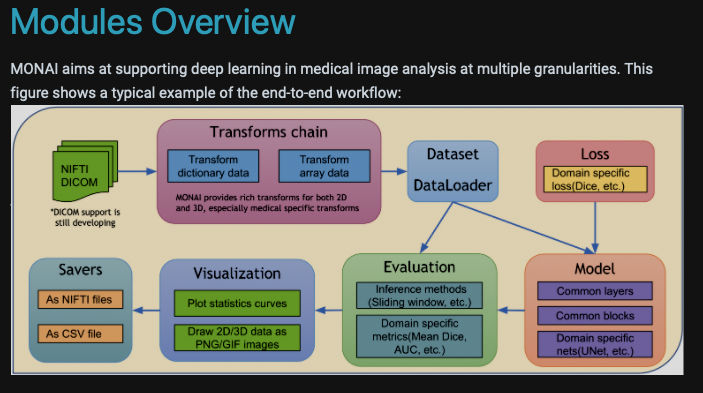








즉, PyTorch + NIfTI 의 결정체..? 무슨 그냥 다하는 것인듯....?? 일단은 그중 밑에서 나중에 쓰일 monai의 다양한 package들을 하나하나 보자

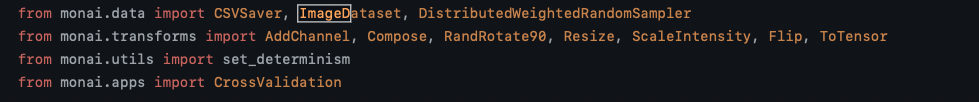

위에중에서 실제로 쓰인느 것들은,
* `ImageDataset`
* `AddChannel`
* `Compose`
* `Resize`
* `ScaleIntensity`
* `ToTensor`

들이다. 이것들만 해도 될듯?

(위에 있는 것들 하나하나 다 적기)


즉 pipeline:
1. `monai.transforms`를 통해서, data를 "transformation"어떻게 할지 (scaling, etc)정하기
2. 앞서 정의한 transformation을, `monai.ImageDataset`/`monai.datasaet`에 넣어서, `torch dataset`처럼 정의하기 
3. 이것을 `torch DataLoader`에 넣어서, torch에 적용하기~!

### 0.1.1. `monai.transforms`종류를 보자
`monai.transforms.XXX`로 불러오는 것들로, transformation을 행하는 packages이다 $\rightarrow$ (image를 로딩하던지, pytorch tensor로 만들던지, scaling을 하던지.. 등등)


* `LoadImage` 
    * `nii/nii.gz` 이미지를 불러와서, `data` ('monai.data.meta_tensor.MetaTensor') and `meta`('dict')를 output한다 (meta : NIfTI header에 있는 meta-data)
* `ScaleIntensity`
    * 0~1 min/max normalization을 'monai.data.meta_tensor.MetaTensor' 에 행하는 것 
* `AddChannel`
    * channel을 앞에 하나 추가하는 것 (i.e. `(H, W, D)` $\rightarrow$ `(C, H, W, D)`
    * 처음에 image loading할때, channel dim이 없는데, 대부분의 monai transform들이 (including pytorch) channel dimension을 필요로 해서 그때 해줌
* `Resize`
    * resizing image to given dimensions (without padding or etc)(only scaling)
* `ToTensor`
    * `monai.data.meta_tensor.MetaTensor` $\rightarrow$ `torch.tensor`로 바꿔줌 
* `Compose`

위의 것들을 볼 것이다 (이 순서로 보는 이유는 나중에 알게됨)


##### 주의 : Some things to note
1. `monai.data.meta_tensor.MetaTensor` datatype이 transform의 input/output으로 주로 쓰임 
    * this datatype contains data and metadata that can be accessed by `XX.data` and `XX,meta` (뒤에 봄)


2. `monai transform` : 대부분의 경우 **[C, H, W, D]** shape로 pytorch의 image와 같은 shape 을 가정하고 operation을 함! (C = 1로 일부로 dimension을 하나 더 둬야할 때도 있음)
    * 그래서 `LoadImage()`를 한 후에, `AddChannel`을 일부러 해줘서 shape를 맞출 필요가 있는 경우가 많다




**for full reference/tutorial:** `notebooks/MONAIBootcamp2021/day1/1.%20Getting%20Started%20with%20MONAI.ipynb` 을 보기 


## ASK : 
* 밑에서 보니까 이미지들을 tensor로 저장해서 그것을 monai transformation거친후 쓰던데, 그냥 `.nii.gz`상태에서 MONAI로 불러와서 할 수 도 있지 않나? 이렇게 하지 않은 이유?
    * 지금은 그렇게 함
* 코드에서 보니, `Resize`를 할때, Padding같은 것을 안해주던데, 그러면 만약 original image가 x*x*x 형태 (즉, perfect cube)가 아니면, 한쪽 방향으로 stretching이 일어날 수 있지 않나? 
    * `Resize`관련 documentation : https://github.com/Project-MONAI/MONAI/blob/dev/monai/transforms/spatial/array.py

#### 0.1.1.1. `AddChannel`


In [2]:
#!nvidia-smi

In [3]:
import torch
import os
from monai.data import ImageDataset
torch.tensor([1,1,1])

/home/connectome/dyhan316/.conda/envs/VAE_3DCNN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([1, 1, 1])

### 0.1.2. `monai.data`안의 있는 것들을 알아보자

코드에서 실제로 쓰이지는 않지만, background info로 알아두면 좋은 것 : 
* `monai.data.dataset` 


코드에서 실제로 쓰이는 것 :
* `monai.data.ImageDataset` : torch에서 `DataLoader`에 들어가는 `Datasaet`이랑 같은 역할을 하는 것! 




#### 0.1.2.1. `monai.data.dataset`

torch dataset이 가져야하는 것들, `__getitem__`, `__len__`이 정의가 되어있는 함수로서, **`torch dataset`** 처럼 사용할 수 있는 것

> 따라서, torch의 `DataLoader`에도 loading가능하다!




from `notebooks/MONAIBootcamp2021/day1/2.%20MONAI%20Datasets%20and%20Caching.ipynb`

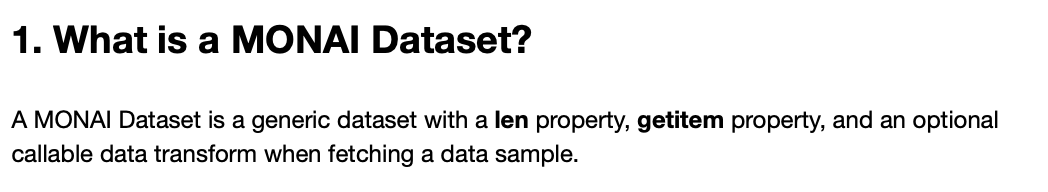

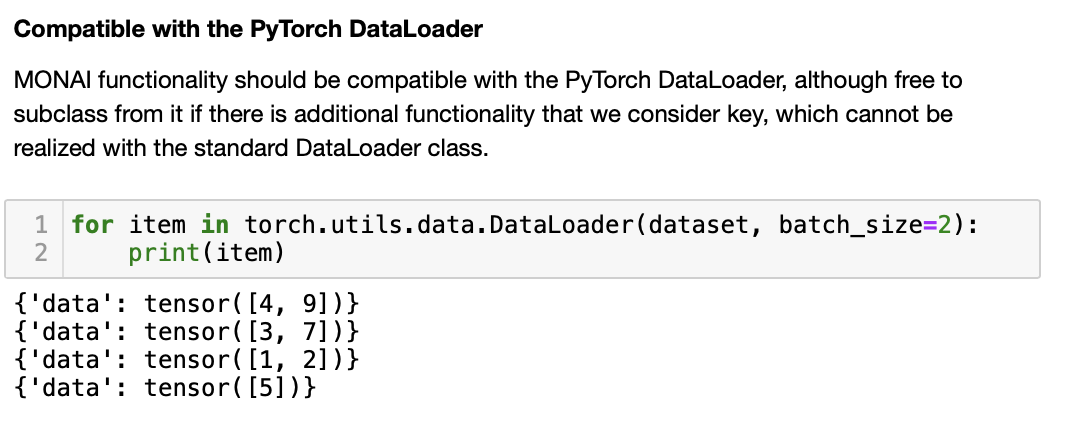

In [4]:
#구체적인 예시는 생략

#### 0.1.2.2 `monai.data.ImageDataset`
이것도, 실제 github코드 찾아보면, `__len__`, `__getitem__`이 정의되어있는, 쉽게 말하면 torch dataloader에 넣어줄 수 있는 아이이다!

output type : `MetaTensor` type of MONAI!

<br>

github code : https://github.com/Project-MONAI/MONAI/blob/dev/monai/data/image_dataset.py



https://docs.monai.io/en/stable/data.html
여기서 `cntrl+F 해서 imagedata` 찾으면 나온다

In [5]:
#실제 구현예시는 밑에 해놓았으니, 그것을 보시유

In [6]:
data_dir = '/scratch/connectome/3DCNN/data/1.ABCD/1.sMRI_fmriprep/preprocessed_masked'
os.chdir(data_dir)
img_list = os.listdir()[:10]
a = ImageDataset(image_files=img_list)

In [7]:
print(type(a))
#print(a.labels)
print(type(a[0])) #즉, 앞에서 `transform`할때의 그 type이다!

print(a[0]) #has added Metadata inside it

print("=========looking at the `MetaData` property of the thing==========")
print(a[0].data.shape)
print(a[0].meta)

<class 'monai.data.image_dataset.ImageDataset'>
<class 'monai.data.meta_tensor.MetaTensor'>
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., -0., 0., 0.],
         [0., 0., 0.,  ..., -0., -0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., -0., 0., 0.],
         [0., 0., 0.,  ..., -0., 0., 0.],
         [0., 0., 0.,  ..., 0., -0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., -0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0

## 0.X 기타 것들
* `tqdm` : 이미 lab2인가 lab3에 tqdm관련해서 정리했습니다 그것 보시면 될듯해요!

이것에 관련해서도 적기!!

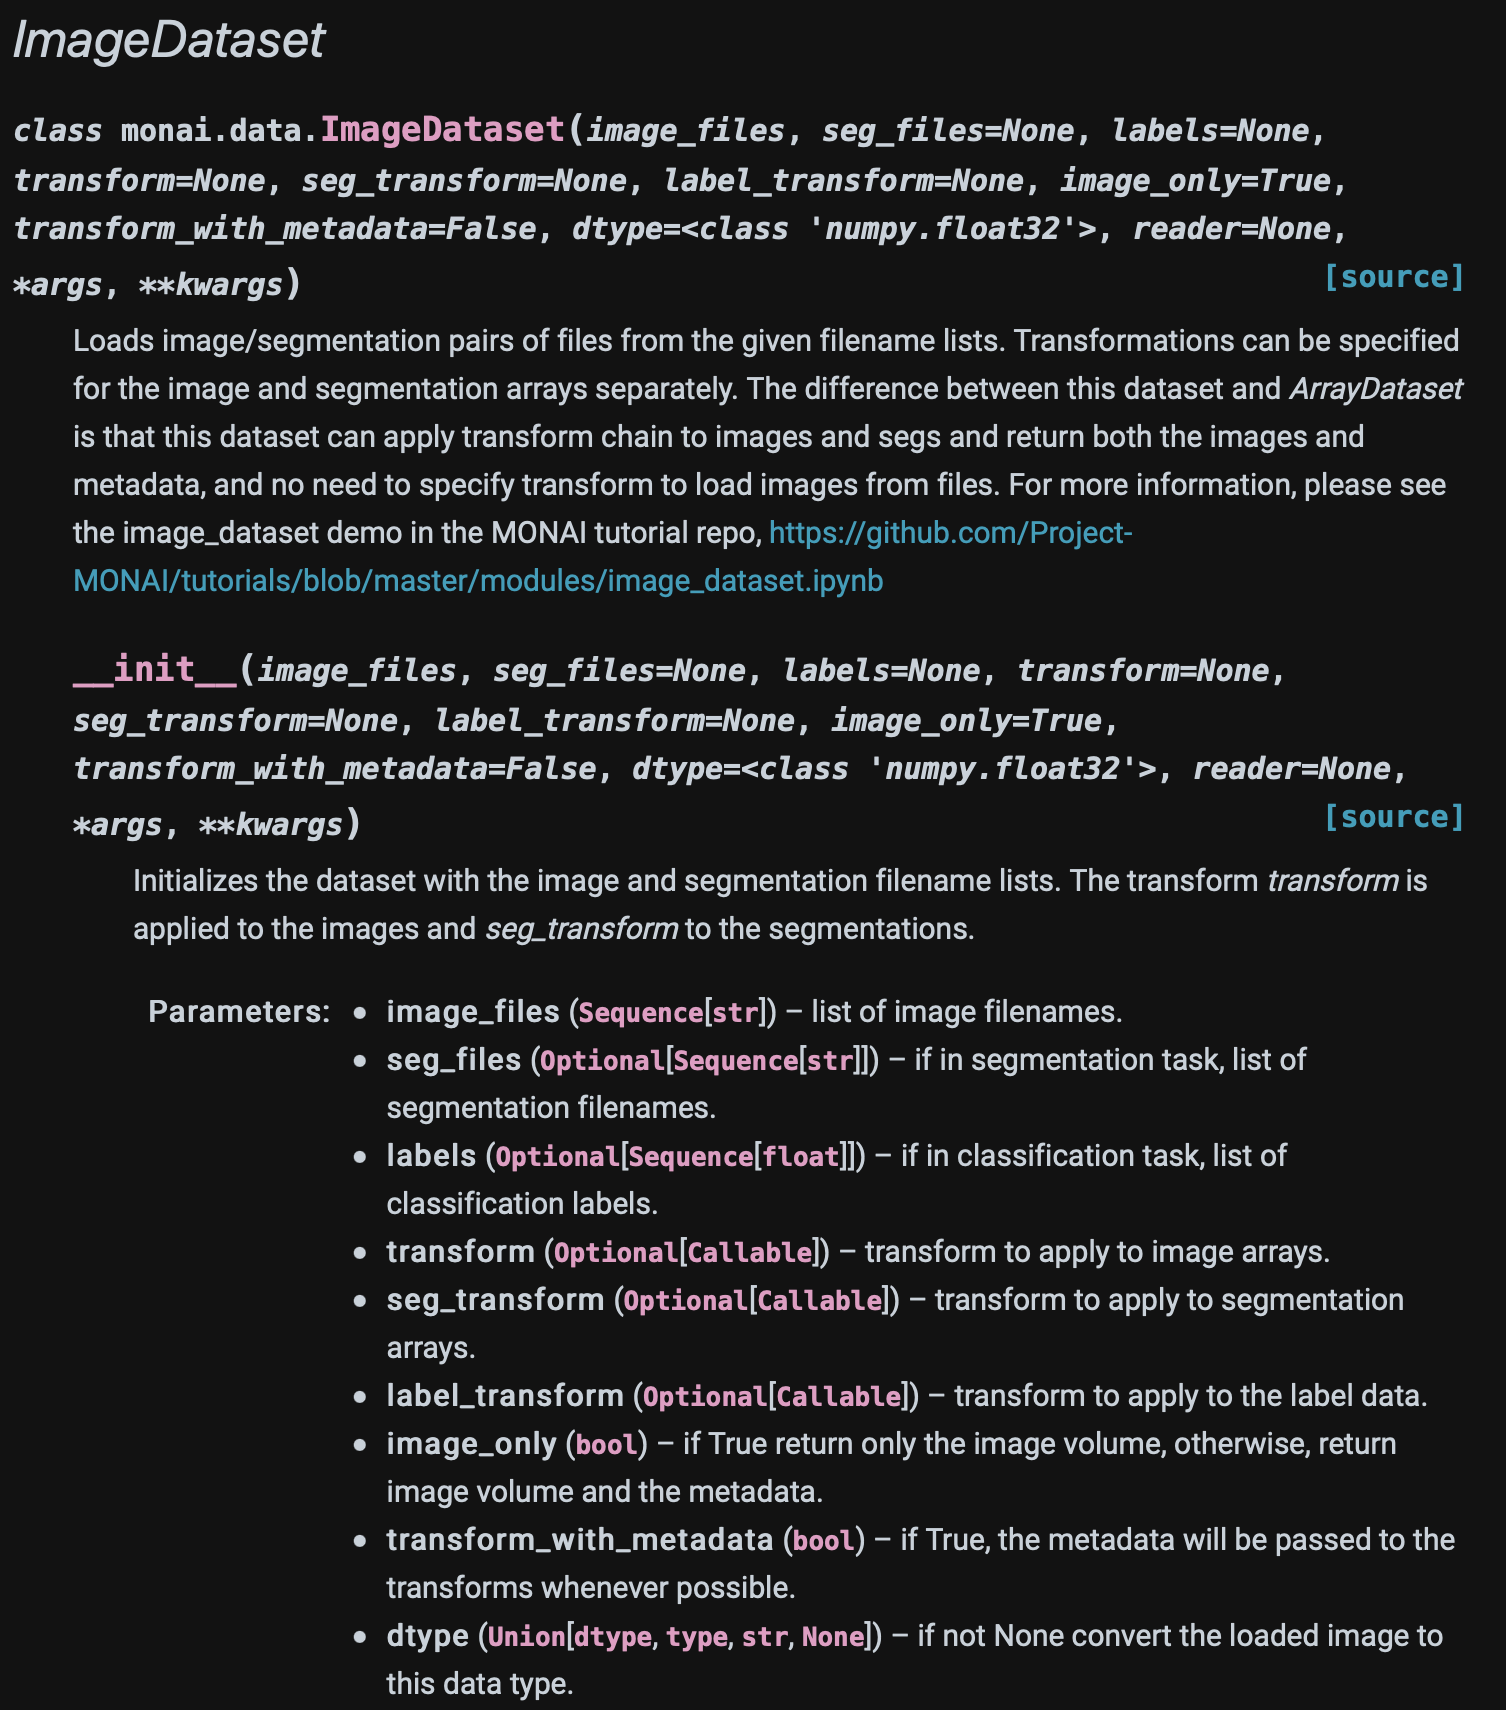

이것 관련해서 적기~!

/home/connectome/dyhan316/.conda/envs/VAE/lib/python3.10/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))

# 1. Basic Setup

## 1.1. Importing files

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
import glob
import os
from tqdm.auto import tqdm
from nilearn import plotting
import matplotlib.pyplot as plt
import pandas as pd
import random
import hashlib
import json
from os import listdir
from os.path import isfile, join
import monai
from monai.data import CSVSaver, ImageDataset, DistributedWeightedRandomSampler
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, Flip, ToTensor
from monai.utils import set_determinism
from monai.apps import CrossValidation

## 1.2. defining args/device
원래는 parser args로 하지만, 여기서는 notebook이니 그냥 args만들어서 하자

**must be filled (set as `None` for now)**
* `model`
* `optim` (Adam으로 지정해 주기는 함)
* `exp_name` (뭔지 몰라서 지정 딱히 안해줌)

In [9]:
class Args():
    def __init__(self):
        self.GPU_NUM =1
        self.model = 'CNN3D_1' ##일단은 이것을 돌려보자 (CNN3D_2 도 있기는 함!) 
        self.val_size=0.1
        self.test_size=0.1
        self.resize=(96,96,96)
        self.train_batch_size=16#16
        self.val_batch_size=8
        self.test_batch_size =8
        self.in_channels =1
        self.out_dim=2
        self.optim = "Adam" #그냥 임의로 내가 넣은 것
        self.lr=1e-5
        self.l2=0.00001
        self.epoch = 10 #그냥 임의로 내가 정한 것 
        self.exp_name = "test_test" #experiment name인것 같다..?
        self.device = 'cuda:0'
args = Args()
##잘됬는지 중간 점검
print(args.epoch)

10


In [10]:
## ========= GPU Setting ========= ##
GPU_NUM = args.GPU_NUM # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print('Experiment will be performed on GPU {}'.format(torch.cuda.current_device()))

Experiment will be performed on GPU 1


## X.X. dsfkjdklsfjdklsfjdklsfds

**밑에 고치기!! 일단은 skip (어떤 것인지 등등도 해야하나 skip)**

In [11]:
#앞에 몇개 보자
!ls -U '/scratch/connectome/3DCNN/data/1.ABCD/1.sMRI_fmriprep/preprocessed_masked' | head -10

NDARINVXPZGM0LG.npy
NDARINV0889M0JE.npy
NDARINVW1M7NAKA.npy
NDARINVGY8VBRN0.npy
NDARINVU61CF84L.npy
NDARINVUU2VUW5T.npy
NDARINVFBD5A7P9.npy
NDARINVKYJCM061.npy
NDARINVVWY740UE.npy
NDARINVHF0D2M6B.npy
ls: write error: Broken pipe


In [12]:
## ========= Data Preprocessing ========= ##
# getting image file names (subject ID + '.npy') as list
base_dir = '/scratch/connectome/3DCNN/data/1.ABCD/1.sMRI_fmriprep/preprocessed_masked'
data_dir = '/scratch/connectome/3DCNN/data/1.ABCD/1.sMRI_fmriprep/preprocessed_masked'
os.chdir(data_dir)
image_files = glob.glob('*.npy')
image_files = sorted(image_files)

In [13]:
# getting subject ID and target variables
target = 'sex'

subject_data = pd.read_csv('/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_phenotype_total.csv')
subject_data = subject_data.loc[:,['subjectkey',target]]
subject_data = subject_data.sort_values(by='subjectkey')
subject_data = subject_data.dropna(axis = 0)
subject_data = subject_data.reset_index(drop=True) # removing subject have NA values in sex

subject_data.head() #i.e. get only the sex and subjectkey


,subjectkey,sex
0,NDARINV003RTV85,2.0
1,NDARINV007W6H7B,1.0
2,NDARINV00BD7VDC,1.0
3,NDARINV00CY2MDM,1.0
4,NDARINV00HEV6HB,1.0


참고로 밑에서 하는 것 : 
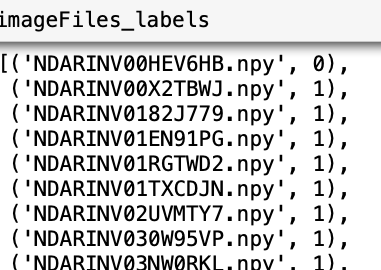
이런 list를 만드는건데... array로 만드는게 더 빠르지 않았을까... 
<br>

밑의 코드가 뭐하는 지 나중에 적기

<br>
밑의 것에서, 너무 오래걸리니 앞에 500명만 하도록 하기

In [14]:
# getting subject ID and target variables as sorted list
imageFiles_labels = []

#############MY MODIFICATIONS###################
image_files = image_files[:100] #앞에 100개만 보자 (나의 코드)
###############################################


for subjectID in tqdm(image_files): #image_files = image files이름들이 실제로 있는 것 
    subjectID = subjectID[:-4] #removing '.npy' for comparing
    #print(subjectID)
    for i in range(len(subject_data)):
        if subjectID == subject_data['subjectkey'][i]:
            if subject_data['sex'][i] == 1:
                imageFiles_labels.append((subjectID+'.npy',0))
            elif subject_data['sex'][i] == 2:
                imageFiles_labels.append((subjectID+'.npy',1))
            else:
                print('NaN value for {}'.format(subjectID))
                continue



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.19it/s]


In [15]:
imageFiles_labels[:10] #i.e. list of tuples

[('NDARINV00HEV6HB.npy', 0),
 ('NDARINV00X2TBWJ.npy', 1),
 ('NDARINV0182J779.npy', 1),
 ('NDARINV01EN91PG.npy', 1),
 ('NDARINV01RGTWD2.npy', 1),
 ('NDARINV01TXCDJN.npy', 1),
 ('NDARINV02UVMTY7.npy', 1),
 ('NDARINV030W95VP.npy', 1),
 ('NDARINV03NW0RKL.npy', 1),
 ('NDARINV059VLAHF.npy', 1)]

## 1.4?? Dataset정의 (with train/test split + basic MONAI transformation (for putting into pytorch)하기)
MONAI transformation (밑의 것들을 `Compose`라는 MONAI 함수로 하나의 함수로 묶기 : 
* `ScaleIntensity` : 0~1로 min/max normalization, 
* `AddChannel` : Channel dimension을 하나 추가로 넣어서, PyTorch형태 (C, H, W, D)로 만들기 (monai transformation도 이 형태의 input을 기대함
* `Resize` : `args.resize`의 형태로 img를 바꾸기 (dimension이 각자 다른 T1 이미지들을 동일한 input size로 통일하기 가능
* `ToTensor()` : `torch.tensor`로 바꿔서 ML돌릴 수 있도록 하기 (그전에는 MONAI의 특정 `MetaTensor`인가 그런 class임)

<br> 

즉, shape의 변천사 가 

1. input : (256,256,256)
2. scale intensity : (256,256,256) 
3. addchannel : (1,256,256,256) 
4. resize : (1,96,96,96) 
5. totensor : (1,96,96,96) (`torch.tensor`)이다!

저기서 `addChannel`을 scale intensity다음에 하는 이유 => 사실 전에하든 후에하든 상관없음 (the added extra dimension has nothing init). However, 그래도 still ScaleIntensity는 AddChannel전에 하는 것이 좋을듯하다.. 왜냐하면 scaling을 channel단위로 하는 것이어야지, 모든 channel을 통틀은 min/max scaling은 하는 것이 아니기 때문. (즉, DWI, T1의 결과들을 (다른 두 channel의 결과들을) 따로따로 scaling하지, 합쳐서 scaling하지 않으니)


## ASK : 
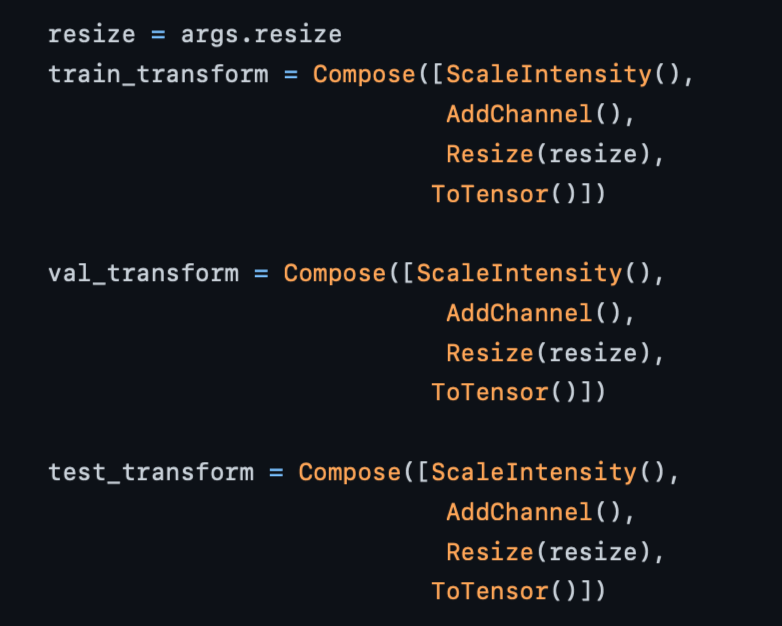
굳이 저렇게 세개의 transform으로 이름을 나눈 이유...? 

하나만 고쳐야 하면 하나만 고칠 수 있도록 generalizability를 위해서 한 것

In [24]:
#defining train/val/test split function #(데이터셋 3개로 split하기)
#ALSO DO BASIC MONAI TRANSFORMATIONS (ScaleIntensity and so on)
def train_test_val_partition(imageFiles_labels, args):
    random.shuffle(imageFiles_labels) #i.e. shuffle the list, (shuffle 후에 parition해야함)
    
    img_set = []
    label_set = [] 
    for one_pair in imageFiles_labels:
        img, label = one_pair
        img_set.append(img)
        label_set.append(label)
    
    
    ##T1 img들이 사이즈등이 다 다를 수 있으니, CNN에 동일한 dimension의 input이 주어지도록, 그리고 0~1 min/max scaling등등을 해주기
    resize = args.resize
    img_transform = Compose([ScaleIntensity(),
                            AddChannel(),
                            Resize(resize),
                            ToTensor()])
    
    num_total = len(img_set)
    num_train = int(num_total*(1 - args.val_size - args.test_size))
    #print(num_train)
    num_val = int(num_total*args.val_size)
    #print(num_val)
    num_test = int(num_total*args.test_size)    
    
    #train/test splitting the `img_set` (using the num_train/num_val/num_test)
    img_train = img_set[:num_train]
    img_val = img_set[num_train:num_train+num_val]
    img_test = img_set[num_train+num_val:num_train+num_val + num_test]
    
    #train/test plitting the `label_set`
    label_train = label_set[:num_train]
    label_val = label_set[num_train:num_train+num_val]
    label_test = label_set[num_train+num_val:num_train+num_val + num_test]

    train_set = ImageDataset(image_files = img_train, labels=label_train, transform= img_transform) #define dataset using monai dataset #can be used to define torch DataLoadewr
    val_set = ImageDataset(image_files = img_val, labels=label_val, transform= img_transform)
    test_set = ImageDataset(image_files = img_test, labels=label_test, transform= img_transform)
    
    
    partitioned_data = {} #define empty dictionary to store as the output
    partitioned_data['train'] = train_set
    partitioned_data['val'] = val_set
    partitioned_data['test'] = test_set   

    return partitioned_data #the output will be a dict with 'train','val',and 'test' as the keys
    

In [25]:
##split the actual dataset using the previously defined partition
partition = train_test_val_partition(imageFiles_labels=imageFiles_labels, args = args)
partition

label_train [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]


{'train': <monai.data.image_dataset.ImageDataset at 0x7f2da8391690>,
 'val': <monai.data.image_dataset.ImageDataset at 0x7f2da78a2690>,
 'test': <monai.data.image_dataset.ImageDataset at 0x7f2da79786d0>}

NameError: name 'img_train' is not defined

## 1.5. Define DataLoader 

앞에서 정의한 `monai.ImageDataset` 으로 `DataLoader`을 정의하자!

must specify
* `dataset` (which one to use)
* `batch_size`
* `shuffle`


<br>

What `DataLoader` gives :
> `[image_batch,label_batch]`의 list


(원래코드에서는 이 파트를 특정 함수 안에 넣어서 하는데, 이해를 위해 여기서는 분리해서 함)

In [18]:
loader_train = torch.utils.data.DataLoader(partition['train'],
                                            batch_size = args.train_batch_size,
                                            shuffle =True 
                                            )
loader_val = torch.utils.data.DataLoader(partition['val'],
                                         batch_size = args.val_batch_size,
                                         shuffle=False, #validation이니 굳이 shuffle필요 없음
                                         num_workers=2
                                        )
loader_test = torch.utils.data.DataLoader(partition['test'],
                                         batch_size= args.test_batch_size,
                                         shuffle=False,
                                         num_workers=2
                                         )

In [19]:
#train loading결과 하나만 보자
sample_train_batch = next(iter(loader_train)) #DataLoader은 iterable object이기 때문에, 이런 방식으로 하나 빼내야함

print("args.train_batch_size : ", args.train_batch_size)
print(type(sample_train_batch)) #as expected, we get a tuple
print([i.shape for i in sample_train_batch]) 

args.train_batch_size :  16
<class 'list'>
[torch.Size([16, 1, 96, 96, 96]), torch.Size([16])]


##### 지금까지 한 것의 깔끔한 정리:
sample batch의 data의 shape가 `torch.Size([16, 1, 96, 96, 96])`인 것은,

```
(batch_size, # of channel, H, W, D))
```
로, 이는

```
(args.train_batch_size, monai addchannel, monai resize(96,96,96))
```
이런 방식들로 얻어진 것이다! 

# 2. Define Model
이제, dataset정의는 끝났으니, 실제로 모델을 정의해보자

* `CNN3D_1`
* `CNN3D_2`

두종류가 있는데 그 중 첫번째를 해보겠다

### ASK:

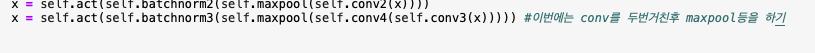
이렇게 한 이유? (즉, conv 두번 한 후 maxpool한 이유...?) (선형대수적ㅇ르로 보면, 이거나 1x7 conv layer 하나 하는 것이나, 수학적으로 동치 아닌가?)



parameter갯수때문에 memory error X => image의 크기자체 때문에 memory error!!

보통 이미 다 정해져있다 (block화) 이런간단한거는 그냥 한다

어떠헥 conv더 쌓냐마냐 보다는 그냥 loss function을 바꾼다

In [20]:
class CNN3D_1(nn.Module): #inherit from nn.Module
    
    #먼저 사용할 아이들을 정의해놓자
    def __init__(self, in_channels, out_dim):
        super(CNN3D_1, self).__init__()
        print(in_channels)
        self.conv1 = nn.Conv3d(in_channels = in_channels, out_channels= 8, kernel_size=3, stride=(1,1,1),padding=1) #참고로 in_channels : input으로 이미 받은 것
        self.conv2 = nn.Conv3d(in_channels = 8, out_channels= 16, kernel_size=3, stride=(1,1,1),padding=1)
        self.conv3 = nn.Conv3d(in_channels = 16, out_channels= 32, kernel_size=3, stride=(1,1,1),padding=1)
        self.conv4 = nn.Conv3d(in_channels = 32, out_channels= 64, kernel_size=3, stride=(1,1,1),padding=1)
        self.conv5 = nn.Conv3d(in_channels = 64, out_channels= 128,kernel_size=3, stride=(1,1,1),padding=1)
        self.conv6 = nn.Conv3d(in_channels = 128, out_channels= 256, kernel_size=3, stride=(1,1,1),padding=1)

        #define batchnorms, which will be done on places with 8, 16, 64 channels
        self.batchnorm1 = nn.BatchNorm3d(8) #8 : channel 갯수
        self.batchnorm2 = nn.BatchNorm3d(16)
        self.batchnorm3 = nn.BatchNorm3d(64)
        
        #define thing that are used over and over
        self.maxpool = nn.MaxPool3d(kernel_size=(2,2,2), stride=(2,2,2)) # 두가지 선택지, 1) padding = 0, kernel = 2; 2) padding = 1, kernel = 3
        self.act = nn.ReLU() #i.e. activation function : ReLU
        
        #define that MLP part (CNN거친후 MLP로 classify)
        #중간에 길이 25짜리의 hidden layer를 하나 가진다고 하자!
        self.classifier = nn.Sequential(
            nn.Linear(6**3*256,25), #CNN거치면 image가 6x6x6 with 256 channels이고, 이것을 25개의 1D vector로 MLP하려는 것
            nn.BatchNorm1d(25), #25-long vector을 1d batch norm
            nn.Sigmoid(), #sigmoid as the activation function!
            nn.Dropout(), #randomly zeros the some elements of the input tensor (p=0.5 by default)
            nn.Linear(25, out_dim) #input인 out_dim의 갯수 (# of targets dimension)
        )
    
    #forward propagation을 앞의 __init__을 써서 정의하지
    def forward(self, x): 
        ## CNN part
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.batchnorm1(x)
        x = self.act(x)
        #x = self.act(self.batchnorm1(self.maxpool(self.conv1(x)))) #first CNN layer (has conv, maxpool and so on)
        x = self.act(self.batchnorm2(self.maxpool(self.conv2(x))))
        x = self.act(self.batchnorm3(self.maxpool(self.conv4(self.conv3(x))))) #이번에는 conv를 두번거친후 maxpool등을 하기
        x = self.act(self.maxpool(self.conv6(self.conv5(x))))
        
        ## Flatten and MLP(self.classifier)
        x = x.view(x.shape[0], -1) #i.e. 첫번째 dimnesion (# of batches)빼고는 전부 flatten하기
        x = self.classifier(x) #not logit btw!!
        
        return x

In [21]:
###instantiate model

net = CNN3D_1(in_channels=args.in_channels, out_dim=args.out_dim)

1


In [22]:
##sample batch하나를 forward pass 해보자
#loader_train에서 하나 뽑아서 forward propagation한번 해보자
sample_batch = next(iter(loader_train))

img, label = sample_batch
print(net(img))

tensor([[ 0.0448,  0.1919],
        [-0.3313,  0.1746],
        [-0.8111,  0.0587],
        [ 0.7991,  0.1710],
        [ 0.3310, -0.2599],
        [ 0.0394, -0.1926],
        [-0.4162, -0.4407],
        [ 0.2379, -0.4468],
        [ 0.0195, -0.5910],
        [ 0.3625, -0.4859],
        [ 0.0712,  0.0214],
        [-0.1419,  0.3426],
        [-0.2127,  0.1494],
        [ 0.0734,  1.0912],
        [ 0.0331,  0.2517],
        [ 0.4557, -0.7204]], grad_fn=<AddmmBackward0>)


# 3. Train/Test/Val loop 정의하기 (for one epoch)

one epoch용 train/test/val loop정의하자 (나중에 실제로 돌릴때 쓰인다)


### ASK:
#### Question 1:
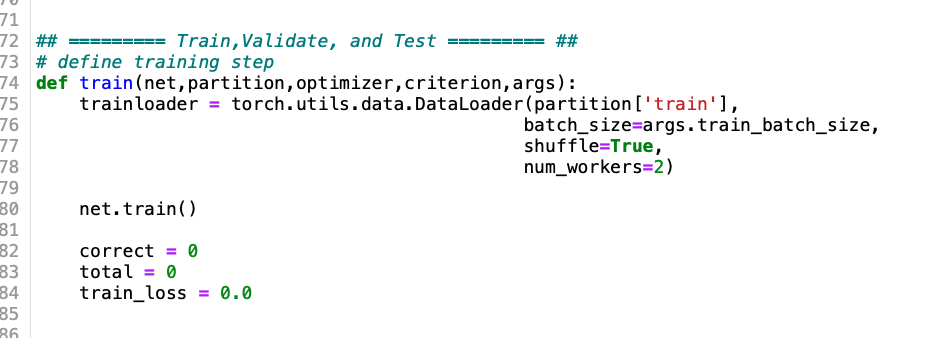
위에서처럼 trainloader을 train loop안에서 정의해주는 이유? (이러면 epoch 돌릴때마다 계속 dataloader다시 정의해야하지 않나?)

#### Question 2: 
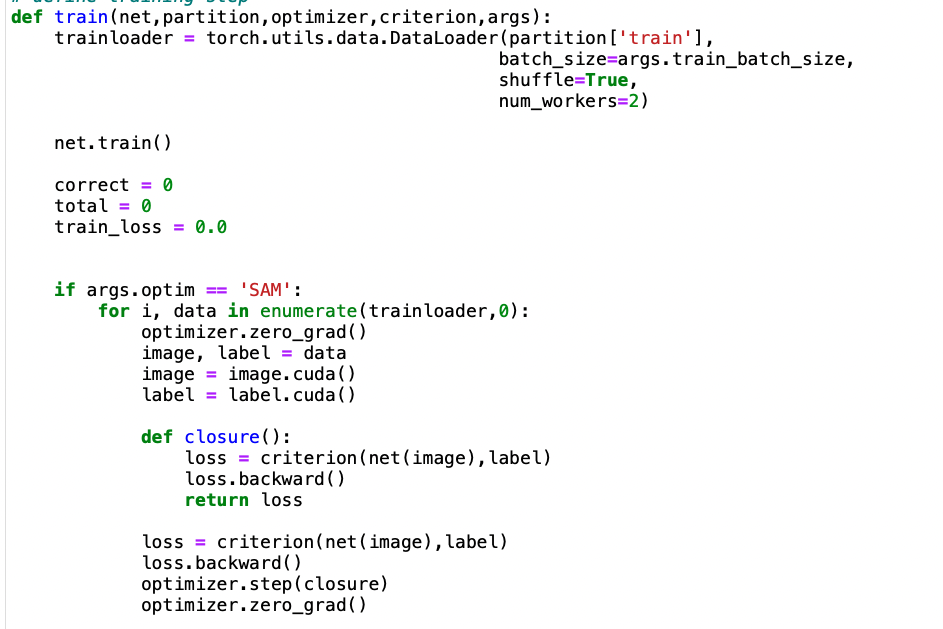
여기서 zero_grad()를 전후에 두번 해준 이유?

#### Question 3:
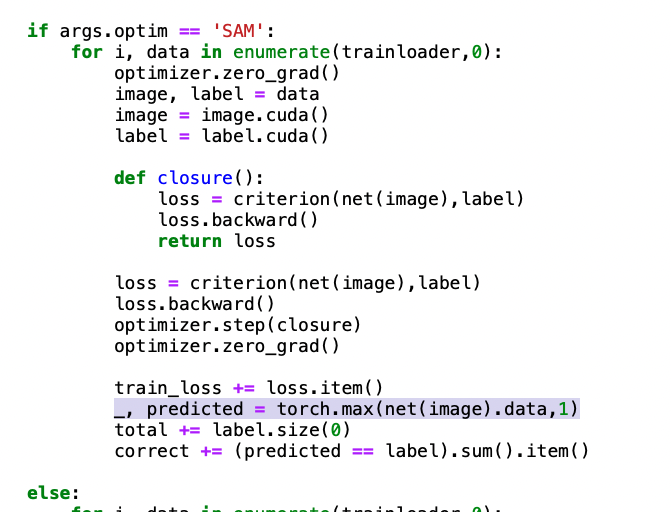
이런식으로 하며 `net(image)`를 여러번 해주는 것인데, 한번만 하고 그것을 가져다가 쓰는게 forward propagatino횟수를 줄 일 수 있지 않나요? 왜 굳이 여러번 쓰나요>?

## 3.1. Trainig Loop
takes as input
* `net` (to be optimized)
* `loader_train` (dataloader)
* `loss_fn` (which function to use to define the loss)
* `optimizer` (much take as input the model.parameters()!!)
* `args` (for device names and so on)


    이것 보기전에, 맨 밑에있는 `S. Supplementary` 인가 거기를 보면, `.item(), .data`를 하는 이유와, `loss` 와 `label_pred`이 사실 어떻게 compute되는지 알 수 있으니, 꼭보기!!

In [23]:
    #tqdm_bar = enumerate(tqdm(loader_train), desc = "Epcoh {}".format(epoch)) #tqdm을 정의할 수 있음나, 원래 코딩에서 안했으니 생략(너무길어짐)

In [24]:
#this train_loop : only over ONE epoch (이 function을 여러번 call 할것이다)
#below : data_loader을 input으로 받도록 하였다!! (not partition )
def train_loop(net, loader_train, loss_fn, optimizer,args):
    net.train() #training mode!
    
    ##setting some global parameters
    device = args.device
    
    ## train_loss, train_acc등을 keep track하기
    train_loss = 0.0
    correct_count = 0
    
    ##run iteration over one epoch 
    for i , data in enumerate(loader_train):
        batch_img, batch_label = data
        
        
        #send data to gpu : not yet (kernel error and etc 나와서 일단은 skip)
        batch_img = batch_img.to(device)
        batch_label = batch_label.to(device)

        #reset optimizer to zero grad -<> predict label -> compute loss -> gradient -> perform gradient descent
        optimizer.zero_grad()
        net_output = net(batch_img)            #netoutput : (16,2)인 model output thingie(not event softmax 거치지도 않음)
        loss = loss_fn(net_output, batch_label) #실제 label과 predicted label로 loss구하기
        loss.backward()
        optimizer.step() 
        
        #accuracy (for this batch) 계산하기(net_output은 그냥 16x2 unnormalized값이고, 이것을 실제로 "prediction" (either (0,1) or (1,0))
        #으로 바꿔야 accuracy등을 계산하기 가능
        #label_pred = 
        
        
        
        train_loss += loss.item() #must extract the tensor!! (therefore used .item())
        #correct_count += 
        
        
        
    
    
        
        
        
        
        
        
        
        
        
        
        
        print(batch_img)
        print(data[0].shape)
        print(data[1])




# S. Supplementary
각종 supplementary things (things to know how the code actually works in the background)를 분야별로 해놓았으니, 그것을 보기


## S.3. Train/Test Loop 관련 supplementary

## S.3.1. Training Loop에서 loss vs accuracy 계산하는 것의 구체적인 deeper look



(밑에 "special" issue라고 하고 적기)

In [25]:
#실제로 loss가 어떻게 계산되는지 tracking해보자
img, label = next(iter(loader_train))   #extract one sample batch

model_output = net(img) 
actual_label = label
print(model_output)
print(actual_label)
#즉, net output자체는 softmax도 안거침 => 따라서, 

#여기서는 getitem으로 tensor빼는 것을 일부로 안함 => 왜냐하면, backprop을 할 것이기 땜누에

tensor([[ 0.1109,  0.2456],
        [-0.2476,  0.2236],
        [-0.1240, -0.6348],
        [-0.3150, -0.0129],
        [-0.0370, -0.3216],
        [-0.1196,  0.3841],
        [ 0.3271, -0.6168],
        [ 0.0243, -0.1001],
        [ 0.3208, -0.3030],
        [-0.1726, -0.2463],
        [-0.4584, -0.0700],
        [-0.2378,  0.2108],
        [ 0.6027, -1.1376],
        [-0.0764,  0.3395],
        [-0.2761,  0.1056],
        [ 0.4055,  0.0190]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0])


In [26]:
loss_fn = nn.CrossEntropyLoss()
loss_value = loss_fn(model_output,actual_label)
#즉, actual_label과 model_output의 형태가 달라도, CrossEntropyLoss는 계산함!
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html 을 보기
# 즉, label vector이 class indices만 가지고 있어도 된다! 
#즉, CrossEntropyLoss : raw score 을 받아서, indices와 비교한다!
#즉, output이 one-hot encoded되어있지 않아도 된다!

In [27]:
##이제 accuracy를 보자
#


##step 1: model_output을 (0,1),(1,0)중에 하나인, "prediction" of the label로 만들어야함
print(model_output.max(dim = 1)) #dim  : dimensino to reduce 
print("=====")
#따라서 위의 것에서 두번째 elewment가 max의 위치를 알려주는 indice이니, 이것을 model prediction으로 정의하자!
model_pred = model_output.max(dim=1)[1] #the indices we get! (실제 원래 것이랑 비교해보기!)
print("model_pred : ",model_pred)


##step2: 이 `model_pred`로, accuracy (for the given batch)를 계산해야한
correct = model_pred == actual_label
#print(correct) #boolean array!
print("accuracy for this batch : ", correct.sum()/len(correct))

torch.return_types.max(
values=tensor([ 0.2456,  0.2236, -0.1240, -0.0129, -0.0370,  0.3841,  0.3271,  0.0243,
         0.3208, -0.1726, -0.0700,  0.2108,  0.6027,  0.3395,  0.1056,  0.4055],
       grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0]))
=====
model_pred :  tensor([1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0])
accuracy for this batch :  tensor(0.4375)


In [28]:
correct.sum()

tensor(7)

### 위에서 쓰였던, .item, .data를 쓴 이유를 밑에서 보자

In [29]:
#item()으로 pop해야하는 이유 
loss = 0.0
print(loss, loss_value)

print("\n====without exctracting .item()====")
print(loss + loss_value) #즉, 이러면 grad_fn이 달라붙음!


print("\n====when extracted using .item()====")
#after extracting .item()
print(loss + loss_value.item())


0.0 tensor(0.8391, grad_fn=<NllLossBackward0>)

====without exctracting .item()====
tensor(0.8391, grad_fn=<AddBackward0>)

====when extracted using .item()====
0.8390957713127136


In [30]:
##.data로, tenosr만 뽑아내야 하는 이유 => 밑에서 둘이 다르다는 것을 볼 수 있는데, 이게 나중에 문제가 될 듯? ==> ASK
print("\n====without exctracting .data()====")
print(torch.max(model_output.data,1))

print("\n====when exctracted using .data()====")
print(torch.max(model_output,1))


====without exctracting .data()====
torch.return_types.max(
values=tensor([ 0.2456,  0.2236, -0.1240, -0.0129, -0.0370,  0.3841,  0.3271,  0.0243,
         0.3208, -0.1726, -0.0700,  0.2108,  0.6027,  0.3395,  0.1056,  0.4055]),
indices=tensor([1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0]))

====when exctracted using .data()====
torch.return_types.max(
values=tensor([ 0.2456,  0.2236, -0.1240, -0.0129, -0.0370,  0.3841,  0.3271,  0.0243,
         0.3208, -0.1726, -0.0700,  0.2108,  0.6027,  0.3395,  0.1056,  0.4055],
       grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0]))


# 4.(??) 실제로 train/test loop 써서 training시키기

In [32]:
##define optimizer

#Adam으로 지정된 경우, `net.parameters`등을 input으로 받는 optimizer만들기!
optimizer = torch.optim.Adam(net.parameters(), lr = args.lr) if args.optim == "Adam" else print("not implemented for this optimizer yet")
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    maximize: False
    weight_decay: 0
)

In [33]:
train_loop(net, loader_train=loader_train, loss_fn= nn.CrossEntropyLoss(), optimizer = optimizer,args = args)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
args.device

# 5. Supplementary/보충 설명

## also, 이것 다보면, dataloader을, VAE/Siamese Twin 용도로 바꿔서 하기!! 
https://www.notion.so/8-15-5138d25a76924ae1bc3ef86439fcb5c5
위의 링크 보면 나옴

In [ ]:
image_files

The code is not well modularized... 뭐 이게 공부용으로는 더 좋기는 하지! :)

## 

In [ ]:
1020/11